# Train Breakout Game on DQN

In [1]:
import os
# !{os.sys.executable} -m pip install gymnasium
# !{os.sys.executable} -m pip install cmake 
# !{os.sys.executable} -m pip install ale-py
# !{os.sys.executable} -m pip install atari-py
# !{os.sys.executable} -m pip install Pillow
# !{os.sys.executable} -m pip install ipython
# !{os.sys.executable} -m pip install pygame
# !{os.sys.executable} -m pip install torchsummary
# !{os.sys.executable} -m pip install tensorboardX
# !{os.sys.executable} -m pip install "gymnasium[atari, accept-rom-licesnse]"
# !{os.sys.executable} -m pip install "autorom[accept-rom-license]"
# !{os.sys.executable} -m pip install torch
# !{os.sys.executable} -m pip install torchvision

In [2]:
# Import useful packages

import os
import sys
import gymnasium as gym
import random
import numpy as np
import json


import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as Fv
import torchvision.transforms as transforms
from torchsummary import summary

from DQN_Model import DQN
from DQN_Model_improved import DQN_improved
from DQN_Model_CNN import DQN_CNN
from tensorboardX import SummaryWriter

from collections import namedtuple, deque


## Configuration 

In [3]:
env_name = "ALE/Breakout-v5" # atari


gamma = 0.99
batch_size = 32 # 32
lr = 0.0001 #1lr = 0.0001
initial_exploration = 1000 #1000
goal_score = 200
log_interval = 1 # 10
update_target = 100 # 100
replay_memory_capacity = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps")
print("Device:", device)

env=gym.make(env_name)

Device: cuda


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


## Memory Class

In [4]:
Transition = namedtuple(
    'Transition', ('state', 'next_state', 'action', 'reward', 'mask')
)

class Memory_DQN(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))
    
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch
    
    def __len__(self):
        return len(self.memory)




## Helper Functions

In [5]:
def get_action(state, target_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample() #random action
    else:
        return target_net.get_action(state)



## Train Function

In [6]:



state_size = env.observation_space.low.size
# state_size = int(state_size / 3) # remove the color from the game. We don't need it
state_shape = env.observation_space.low.shape
    
action_size = env.action_space.n

print("state_shape", state_shape, "state_size", state_size)
print("action_size", action_size)




# Define the models
online_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
online_net.train()
target_net.train()

writer = SummaryWriter('logs')

summary(online_net, input_size = (batch_size, state_size)) 


optimizer = optim.Adam(online_net.parameters(), lr=lr)
N_EPISODES = 500 # 5000

#initialize running variables
running_score = 0
epsilon = 1.0
epsilon_decay_rate = 0.000005 #0.000005
steps = 0
loss = 0

# initialize the memory bank
memory = Memory_DQN(replay_memory_capacity)

# Before training
loss_record = []
scores_record = []
best_score = float('-inf')  # Initialize best_score with negative infinity
best_online_net_weights = None
best_target_net_weights = None


state_shape (210, 160, 3) state_size 100800
action_size 4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 128]      12,902,528
            Linear-2                [-1, 32, 4]             516
Total params: 12,903,044
Trainable params: 12,903,044
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.30
Forward/backward pass size (MB): 0.03
Params size (MB): 49.22
Estimated Total Size (MB): 61.56
----------------------------------------------------------------


In [7]:
for episode in range(N_EPISODES):
    done = False

    score = 0
    state = env.reset()[0]
    state = torch.Tensor(state).to(device)
    state = torch.flatten(state)

    while not done:
        steps += 1
        action = get_action(state, target_net, epsilon, env)
        
        next_state, reward, terminated, truncated,_ = env.step(action)
        done = terminated or truncated

        
        next_state = torch.Tensor(next_state).to(device)
        next_state = torch.flatten(next_state)

        mask = 0 if done else 1 #don't know what this line does

        # i assume this is the penalty function?
        reward = reward if not done or score == 499 else -1

        action_one_hot = np.zeros(action_size)
        action_one_hot[action] = 1

        # add to memory bank
        memory.push(state, next_state, action_one_hot, reward, mask)

        score += reward
        state = next_state

        if steps > initial_exploration:
            epsilon -= epsilon_decay_rate
            epsilon = max(epsilon, 0.01)

            # process the batch
            batch = memory.sample(batch_size)
            # print("batch", batch)
            states = torch.stack(batch.state).to(device)
            next_states = torch.stack(batch.next_state).to(device)
            actions = torch.Tensor(np.array(batch.action)).float().to(device)
            rewards = torch.Tensor(batch.reward).to(device)
            masks = torch.Tensor(batch.mask).to(device)
            
            # print("states", states.shape)
            
            q_values = online_net(states).gather(1, actions.long())
            next_q_values = target_net(next_states).to(device)
            
            masks_broadcasted = masks.unsqueeze(1).to(device)  # Shape [32, 1]
            duplicated_rewards = rewards.unsqueeze(1).repeat(1, action_size).to(device)

            
            q_target  = duplicated_rewards + gamma * next_q_values*masks_broadcasted
            q_target.to(device)

            
            loss = F.mse_loss(q_values, q_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if steps % initial_exploration:
                target_net.load_state_dict(online_net.state_dict())
    score = score if score == 500.0 else score + 1
    if running_score == 0:
        running_score = score
    else:
        running_score = 0.99 * running_score + 0.01 * score

    scores_record.append(running_score)
    loss_record.append(loss)

     # Update best_score and store best model weights in memory
    if running_score > best_score:
        best_score = running_score
        best_online_net_weights = online_net.state_dict()
        best_target_net_weights = target_net.state_dict()
    
    if episode % log_interval == 0:
        print('\r{} episode | score: {:.2f} | loss: {:.5f} | epsilon: {:.2f}'.format(
            episode, running_score, loss, epsilon), end='')
        writer.add_scalar('log/score', float(running_score), episode) # i don't know what this does
        writer.add_scalar('log/loss', float(loss), episode)    

    if running_score > goal_score:
        break
            
            

            
            
        

499 episode | score: 2.84 | loss: 0.03154 | epsilon: 0.468233345

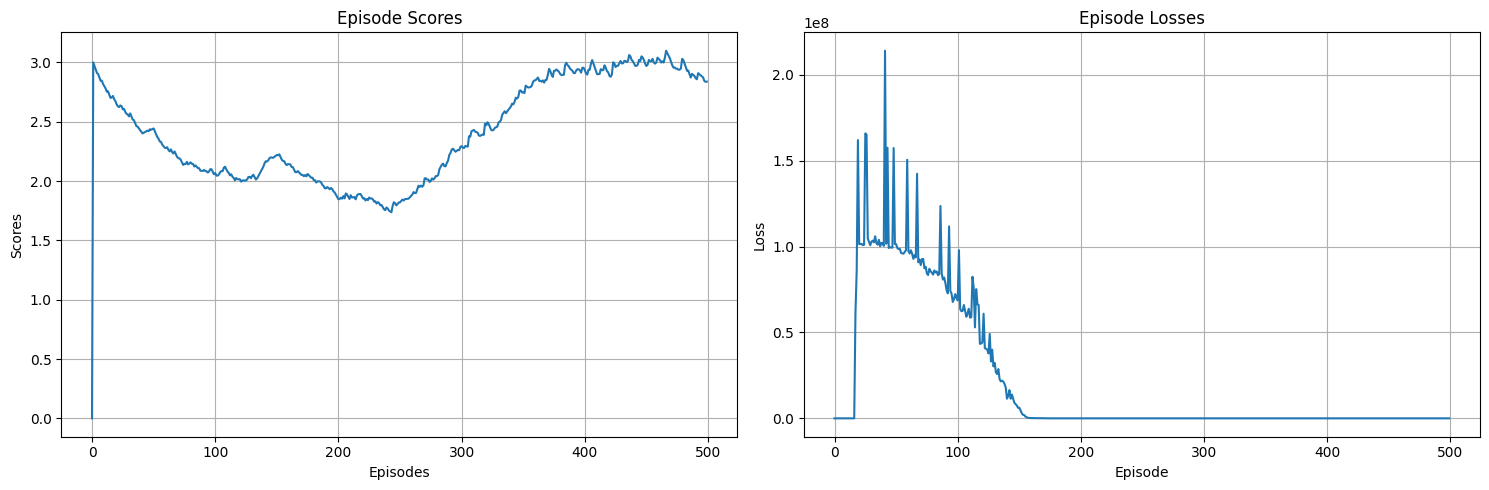

In [8]:
import matplotlib.pyplot as plt
import os
import time

# Create the saved_models folder if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Generate a unique train_number based on current timestamp
train_number = time.strftime("%Y%m%d_%H%M%S")
train_folder = f'saved_models/train_{train_number}'

# Create the train_number subfolder inside saved_models
if not os.path.exists(train_folder):
    os.makedirs(train_folder)

# Save the model to the train_number subfolder
torch.save(online_net.state_dict(), f'{train_folder}/online_net.pth')
torch.save(target_net.state_dict(), f'{train_folder}/target_net.pth')

# Save the best model weights to the train_number subfolder
torch.save(best_online_net_weights, f'{train_folder}/best_online_net.pth')
torch.save(best_target_net_weights, f'{train_folder}/best_target_net.pth')

def convert_to_ints(lst):
    return [int(elem.item()) if torch.is_tensor(elem) else int(elem) for elem in lst]

# Save scores_record to a file
with open(f'{train_folder}/scores_record.json', 'w') as f:
    json.dump(scores_record, f)

# Save loss_record to a file
with open(f'{train_folder}/loss_record.json', 'w') as f:
    json.dump(convert_to_ints(loss_record), f)

# Plotting the metrics
plt.figure(figsize=(15, 5))

# Plot Rewards
plt.subplot(1, 2, 1)
plt.plot(scores_record)
plt.title('Episode Scores')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.grid(True)

# Plot Losses (assuming you have a list of losses)
plt.subplot(1, 2, 2)
plt.plot(convert_to_ints(loss_record))
plt.title('Episode Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

# Save the plots to the train_number subfolder
plt.savefig(f'{train_folder}/metrics_plot.png')

plt.tight_layout()
plt.show()
